In [1]:
import ReadRawMHD as rR
import mapping_noRot as mappNR
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import time
import os
t1 = time.time()

In [2]:
# # # # # Input # # # # #
# Input imaging data
# FE version
models = ['00_L50_S50_D30', '01_L50_S50_D35', '02_L50_S50_D40', '03_L50_S50_D45', '04_L50_S50_D27',  # 0, 1, 2, 3, 5
          '10_L50_S00_D30', '11_L50_S00_D35', '12_L50_S00_D40', '13_L50_S00_D45', '14_L50_S00_D27', '15_L50_S00_D44',
          '31_L50_S50_D35', '43_L50_S00_D45',  # 11, 12
          '50_L50_S00_D30', '55_L50_S00_D30',  # 13, 14
          '63_L50_S50_D45', '74_L50_S50_D45', '75_L50_S50_D45',  '76_L50_S50_D45', '77_L50_S50_D45',  # 15, 16, 17, 18, 19
          '80_L50_S50_D45', '83_L50_S50_D45']  # 20, 21


model_code = models[20]  # FEA model name
print('Model: ' + str(model_code))
sample_code = 'S131318_L1_left'  # Experimental sample. contains number and sample name, e.g. 00_Pilot3
ExpScrew = 'P'  # T or P, site from experiment. Two input files (SimScrew Ti and PEEK) will always be generated

Model: 80_L50_S50_D45


In [3]:
# Specify file locations
#---sample_no, sample = sample_code.split('_')  # sample name and number
path_project = '/home/biomech/Documents/01_Icotec/'  # General project folder
path_ct = path_project + '01_Experiments/02_Scans/' + sample_code + '/04_Registered/'  # Folder of CT data
path_fea = path_project + '02_FEA/98_Pilots/' + sample_code + '/' + model_code + '/'  # Folder of FEA files
print(os.listdir(path_ct + '/'))
file_bone = [filename for filename in os.listdir(path_ct + '/') if filename.endswith('image.mhd') and str(sample_code) in filename][0]
#file_inst = [filename for filename in os.listdir(path_ct + '/') if filename.endswith('crop.mhd') and 'mask' in filename][0]
# Include general path for mesh/template later
# HERE commented info
# info = sample_code + ExpScrew + '_info.txt'  # .txt file containing info about landmarks. Specific structure
print(file_bone)
#print(file_inst)

['S131318_L1_left_screw_image.mhd', 'S131318_L1_left_screw_image.raw', 'S131318_L1_left_scrxew_imxage_original_copy.mhd']
S131318_L1_left_screw_image.mhd


In [4]:
# # # # # Input # # # # #
# Input FEA data
Input = {}
Input['Project_Folder'] = path_project
Input['FEA_loc'] = path_fea  # path to FEA files
Input['Model_Code'] = model_code  # model code (FEA model name)
Input['Screw'] = ExpScrew  # which site of scan will be processed
Input['Resolution'] = 0.0606995  # scan resolution, should be 0.0606995 for HR-pQCT II

Input['Load_mode'] = 'd'  # no effect 'd' or 'f', displacement or force controlled
## ********* EXCLUDED (line 357 in mapping.py)

Input['d_dir'] = '-'  # displ direction (negative corresponds to experiment, positive = inverse). Input: '-' or '+'
Input['d_max'] = 1  # peak displ


Input['Friction'] = 0.2  # friction between screw and bone
Input['Mapping_Diameter'] = 2.5  # diameter of sphere for mapping, in mm. should be larger than element size

# parametrise screw length? --> different mesh sizes // ROI? // step size?

# Check if folder exists, otherwise create it
isExist = os.path.exists(Input['FEA_loc'])
if not isExist:
    os.makedirs(Input['FEA_loc'])
    print('New directory created: ' + Input['FEA_loc'])

# Submit on cortex or ubelix?
# -> Other parameters as e-mail, runtime, memory etc. can be changed in the template file
Input['Submit'] = 'ubelix'
mappNR.write_submit(Input)

# Take screw axis or points from PMMA area
screw_axis = 1

# Write output images? segmented image and mask, for visual check
write_output = 1

In [5]:
# Write mesh input file
mappNR.write_mesh(Input)  # Original input file, path for mesh.inp

Finished extracting mesh file.


In [6]:
# Load data screw information from .txt file
# About file:
# Origin is where screw enters bone, will be origin of bone-mesh
# Rotation axis positive x axis: Point on rotation axis (where bone is fixed in testing machine), positive x-coordinate
# Rotation axis negative x axis: Point on rotation axis (where bone is fixed in testing machine), negative x-coordinate
#imD = rR.load_itk(path_ct + file_inst)  # screw image
#with open(path_ct + info, 'r') as f:
#    content = f.read()
#ori = content.split('Origin: ')[1].split('\n')[0]
#ori = np.array([int(ori.split(' ')[0]), int(ori.split(' ')[1]), int(ori.split(' ')[2])])
#p1P = content.split('positive x axis: ')[1].split('\n')[0]
#p1P = np.array([int(p1P.split(' ')[0]), int(p1P.split(' ')[1]), int(p1P.split(' ')[2])])
#p1N = content.split('negative x axis: ')[1].split('\n')[0]
#p1N = np.array([int(p1N.split(' ')[0]), int(p1N.split(' ')[1]), int(p1N.split(' ')[2])])
#screw_start = np.array(int(content.split('Screw detection start (head): ')[1].split('\n')[0]))
#screw_stop = np.array(int(content.split('Screw detection stop (tip): ')[1].split('\n')[0]))
#print(screw_start)
#print(screw_stop)
#print(ori)
#print(p1P)
#print(p1N)

#ori = np.array([0, 0, 0])
#p1P = np.array([100, 0, 0])
#p1N = np.array([0, 0, 0])
#screw_start = 0
#screw_stop = 1
#print(type(ori))
#print(type(p1P))
#print(type(p1N))

In [7]:
# # # # # Input # # # # #
# Define screw vector
#v3 = []
#if ExpScrew == 'T':
    #lineT = rR.axis3D(imD[0], screw, 1100, 'x')  # if starting from screw tip towards head, add (-) to v3  pilot3 -
    #lineT = rR.axis3D(imD[0], 333, 618, 'x')  # pilot4 +
    #lineT = rR.axis3D(imD[0], 332, 579, 'x')  # pilot5 +
#    if screw_axis:
#        if screw_start > screw_stop:
#            lineT = rR.axis3D(imD[0], screw_stop, screw_start, 'x')
#            v3 = -lineT.vector
#        elif screw_start < screw_stop:
#            lineT = rR.axis3D(imD[0], screw_start, screw_stop, 'x')
#            v3 = lineT.vector
#elif ExpScrew == 'P':
    #lineT = rR.axis3D(imD[0], 0, 600, 'x')  # if starting from screw tip towards head, add (-) to v3  pilot3 +
    #lineT = rR.axis3D(imD[0], 763, 1320, 'x')  # pilot4 -
    #lineT = rR.axis3D(imD[0], 760, 1311, 'x')  # pilot5 -
#    if screw_axis:
#        if screw_start > screw_stop:
#            lineT = rR.axis3D(imD[0], screw_stop, screw_start, 'x')
#            v3 = -lineT.vector  # z-axis = screw axis, found by function. Specify +/-!!!!!!!
#        elif screw_start < screw_stop:
#            lineT = rR.axis3D(imD[0], screw_start, screw_stop, 'x')
#            v3 = lineT.vector
#del imD
#print(v3)

In [8]:
# Compute matrix
#v3 = [607, 416, 537] - ori  # HERE manually entered screw tip, Pilot6, P
#v3 = ori - [824, 436, 444]  # HERE manually entered screw tip, Pilot6, T
#v3 = np.array([0, 0, 1])
#print(v3/np.linalg.norm(v3))
#v2 = np.cross(v3, p1P-p1N)/np.linalg.norm(np.cross(v3, p1P-p1N))  # y-axis
#v1 = np.cross(v2, v3)  # x-axis
#M = np.vstack((np.append(v1, ori[0]), np.append(v2, ori[1]), np.append(v3, ori[2]), np.array([0, 0, 0, 1])))
#print(v2)
#print(M)

In [9]:
# Check coordinate system
# z-axis (blue) should point from screw head (origin) towards screw tip (dot)
# y-axis (green) should be perpendicular to screw-rotAxis plane and point upwards (against loading direction)
# x-axis (red): right-handed coordinate system
#%matplotlib notebook
#plt.figure()
#ax = plt.axes(projection='3d')
#fact = 100
#for i in range(0, 5):
#    ax.scatter3D(ori[0]+i*fact*v1[0], ori[1]+i*fact*v1[1], ori[2]+i*fact*v1[2], c='r', alpha=1)
#    ax.scatter3D(ori[0]+i*fact*v2[0], ori[1]+i*fact*v2[1], ori[2]+i*fact*v2[2], c='g', alpha=1)
#    ax.scatter3D(ori[0]+i*fact*v3[0], ori[1]+i*fact*v3[1], ori[2]+i*fact*v3[2], c='b', alpha=1)
#ax.scatter3D([0, 1500], [0, 1500], [0, 1500], alpha=0)
#ax.scatter3D(p1P[0], p1P[1], p1P[2], c='k')
#ax.scatter3D(p1N[0], p1N[1], p1N[2], c='k')
#ax.scatter3D(ori[0], ori[1], ori[2], c='c')
#ax.scatter3D(879, 486, 799, c='m')  # tip 621 476 806
#ax.scatter3D(879, 100, 799, c='r')  # force direction (negative!)
#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.set_zlabel('z')
#plt.show()

In [10]:
bone = {}
bone = mappNR.readInpBoneDummy(bone, Input)  # Read bone mesh from abaqus. Read elements, nodes

/home/biomech/Documents/01_Icotec/04_Code/venv/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


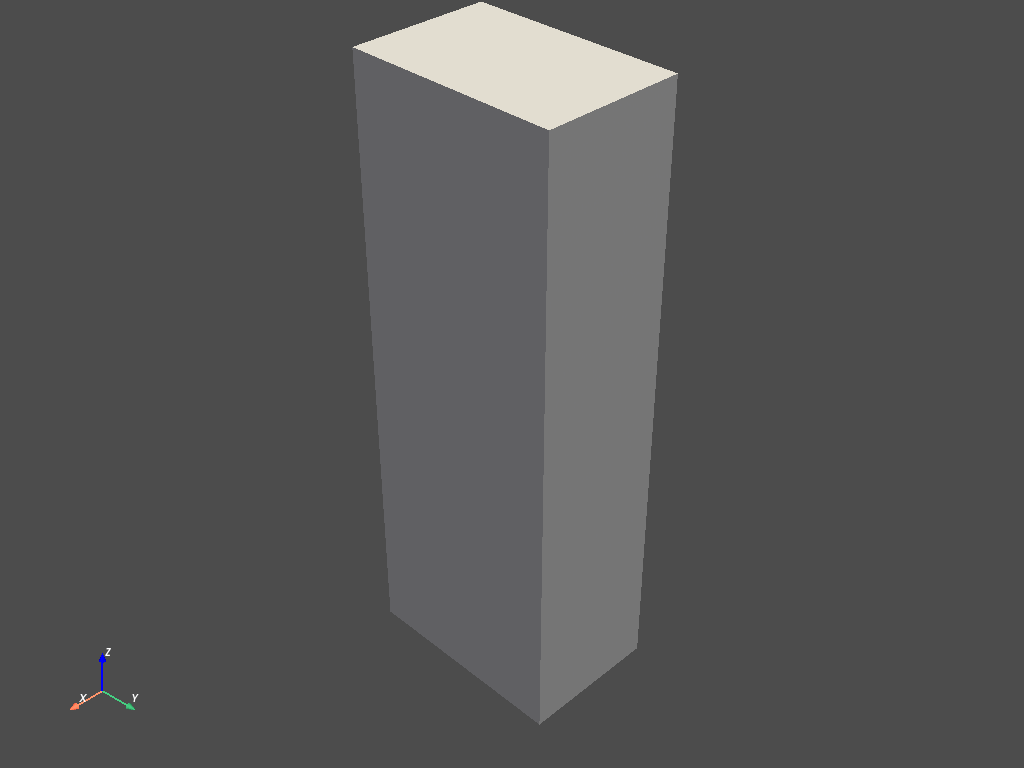

In [ ]:
bone = mappNR.boneMeshMask(bone, Input)  # Create mask from abaqus bone mesh

In [ ]:
bone = mappNR.load_BVTVdata(bone, path_ct + file_bone)

In [ ]:
# Read mask
imMask = sitk.ReadImage(Input['FEA_loc'] + Input['Model_Code'] + Input['Screw'] + '_mask.mhd')
imMask_np = np.transpose(sitk.GetArrayFromImage(imMask), [2, 1, 0])
print(bone["GreyImage"].GetOrigin())
print(bone["GreyImage"].GetOrigin()*bone["GreyImage"].GetSpacing())
#bone["GreyImage"].SetOrigin([0, 0, 0])
# Define rotation and translation
#[theta1, theta2, theta3] = rR.rotation_angles_from_matrix(M[:3, :3], 'zyx')
# HERE commented
#theta1 = theta1
#theta2 = theta2 + np.pi  # +pi because arc-tan has no unique solution. NEGATIVE, because mask[:, ::, :] reshaped
#theta3 = theta3
center = np.array([imMask_np.shape[0] / 2, imMask_np.shape[1] / 2, 0]) * imMask.GetSpacing()
#trans = M[:3, 3] * imMask.GetSpacing() - center
# HERE overwriting angles
#trans = [40, 12, 15]
#theta1 = 0.0873
#theta2 = 0.7854
#theta3 = 0.0
#print(theta1)
#print(theta2)
#print(theta3)
#print(trans)

In [ ]:
# Write transformation file
#f = open(path_fea + 'transformation_' + model_code + ExpScrew + '.tfm', "w")
#f.write(
#    "#Insight Transform File V1.0\n"
#    "#Transform 0\n"
#    "Transform: CompositeTransform_double_3_3\n"
#    "#Transform 1\n"
#    "Transform: Euler3DTransform_double_3_3\n"
#    "Parameters:  " + f'{theta1}' + " " + f'{theta2}' + " " + f'{theta3}'
#    + " " + f'{trans[0]}' + " " + f'{trans[1]}' + " " + f'{trans[2]}' + "\n"  # transformation
#    "FixedParameters: " + f'{center[0]}' + " " + f'{center[1]}' + " " + f'{center[2]}' + " 0\n")  # CoR
#f.close()

In [ ]:
# Apply transformation to mask using the inverse transformation
#bone['Transform'] = sitk.ReadTransform(path_fea + 'transformation_' + model_code + ExpScrew + '.tfm')
#bone['Transform_inv'] = bone['Transform'].GetInverse()
#imMask_trans = sitk.Resample(imMask, bone['GreyImage'], bone['Transform_inv'], sitk.sitkNearestNeighbor, 0.0, bone['GreyImage'].GetPixelID())
# Delete some files / variables to save memory

bone['MASK'] = imMask_np
if write_output:
    img_seg=sitk.GetImageFromArray(np.transpose(bone['BVTVscaled'], [2, 1, 0]))
    img_seg.SetOrigin(bone["GreyImage"].GetOrigin())
    img_seg.SetSpacing(bone["GreyImage"].GetSpacing())
    sitk.WriteImage(img_seg, path_fea + sample_code + '_seg.mhd')
    print('Segmented image saved.')
    #imMask_trans.SetOrigin(bone["GreyImage"].GetOrigin())
    #imMask_trans.SetSpacing(bone["GreyImage"].GetSpacing())
    #sitk.WriteImage(imMask_trans, path_fea + model_code + '_' + ExpScrew + '_maskTrans.mhd')
    print('Transformed mask saved.')
    print('Original mask saved.')
    del img_seg
else:
    os.remove(path_fea + model_code + ExpScrew + '_mask.mhd')
    os.remove(path_fea + model_code + ExpScrew + '_mask.raw')
del bone['GreyImage']

In [ ]:
# BVTV segmentation / calibration HR-pQCT to uCT
#bone['MASK_array_T'] = np.transpose(sitk.GetArrayFromImage(imMask_trans), [2, 1, 0])
# scaling factor/intercept from Schenk et al. 2022, has to be discussed w Ph
mappNR.HFE_mapping_trans(bone, Input)

In [ ]:
#sliceNo = ori[1]-100
#plt.figure()
#plt.imshow(bone['BVTVscaled'][:, sliceNo, :] + bone['MASK_array_T'][:, sliceNo, :])
#plt.show()

In [ ]:
#sliceNo = ori[1]
#plt.figure()
#plt.imshow(bone['BVTVscaled'][:, sliceNo, :] + bone['MASK_array_T'][:, sliceNo, :])
#plt.show()

In [ ]:
#sliceNo = ori[1]+100
#plt.figure()
#plt.imshow(bone['BVTVscaled'][:, sliceNo, :] + bone['MASK_array_T'][:, sliceNo, :])
#plt.show()

In [ ]:
# Write final input file
mappNR.HFE_inp_creator(Input)
if not write_output:
    os.remove(Input['FEA_loc'] + Input['Model_Code'] + Input['Screw'] + '_elsets.inp')
    os.remove(Input['FEA_loc'] + Input['Model_Code'] + Input['Screw'] + '_materials.inp')
    os.remove(Input['FEA_loc'] + Input['Model_Code'] + '_mesh.inp')
#    os.remove(Input['FEA_loc'] + 'transformation_' + Input['Model_Code'] + Input['Screw'] + '.tfm')

In [ ]:
tRun = time.time()-t1
if tRun >= 3600:
    print('Execution time: ' + str(int(tRun/3600)) + ' h ' + str(int(np.mod(tRun, 3600)/60)) + ' min '+ str(round(np.mod(tRun, 60), 1)) + ' sec.')
elif tRun >= 60:
    print('Execution time: ' + str(int(tRun/60)) + ' min '+ str(round(np.mod(tRun, 60), 1)) + ' sec.')
else:
    print('Execution time: ' + str(round(tRun, 1)) + ' sec.')